In [4]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [5]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.columns)
print(df_all_sorted.head())



astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
Index(['TIME_NS', 'TIME_S', 'TIME_ABS', 'EVENT', 'MCRUN', 'TEL_ID', 'HG', 'LG',
       'TTP'],
      dtype='object')
   TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0   238868       0    238868   1007  263210       2   
1  1029262       0   1029262   3519  263210       2   
2  1030456       0   1030456   3519  263210       9   
3  3274338       0   3274338   3803  263210       9   
4  3678725       0   3678725   3805  263210       2   

                                                  HG  \
0  [[2156, 2287, 2081, 2114, 2197, 2323, 2141, 22... 

mc=266033, ev=3109


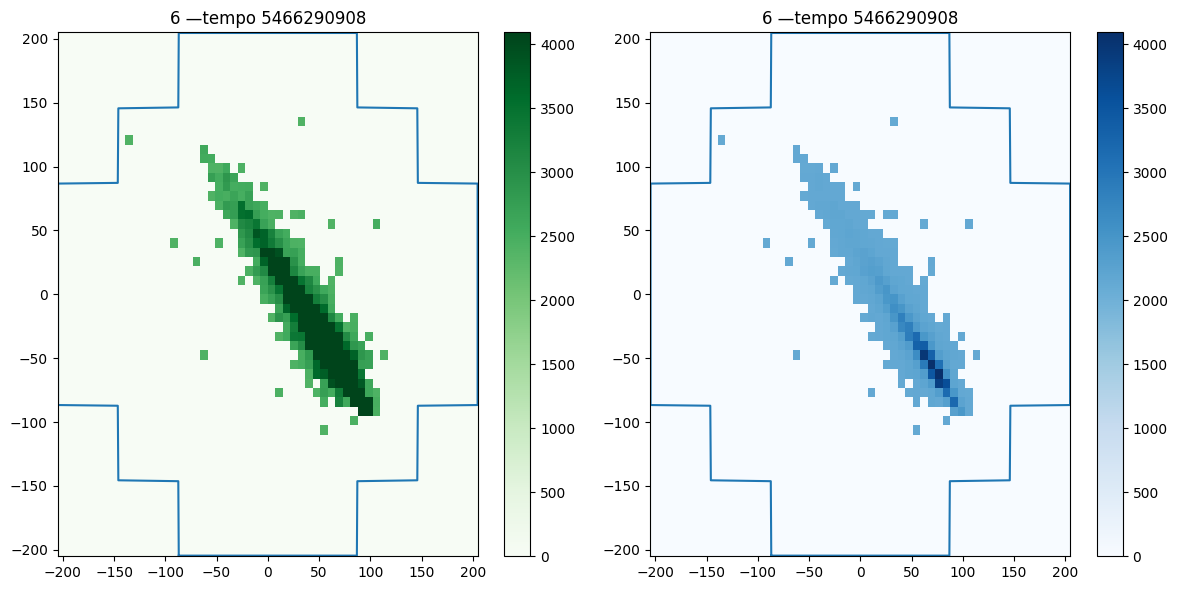

In [6]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

event_energies = df_all_sorted['HG'].apply(np.sum)
top_indices = np.argsort(event_energies)[-5:]
#i 3 eventi più energetici in assoluto tra tutti i file
for iev in top_indices[0:1]:
    print(f"mc={df_all_sorted['MCRUN'][iev]}, ev={df_all_sorted['EVENT'][iev]}")
    
    # ciclo sui primi eventi piu energetici
    #for iev in range(10):
    hgev = np.array(df_all_sorted['HG'])[iev]
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
            # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()

#print(np.shape(top_indices))
#print(event_energies)

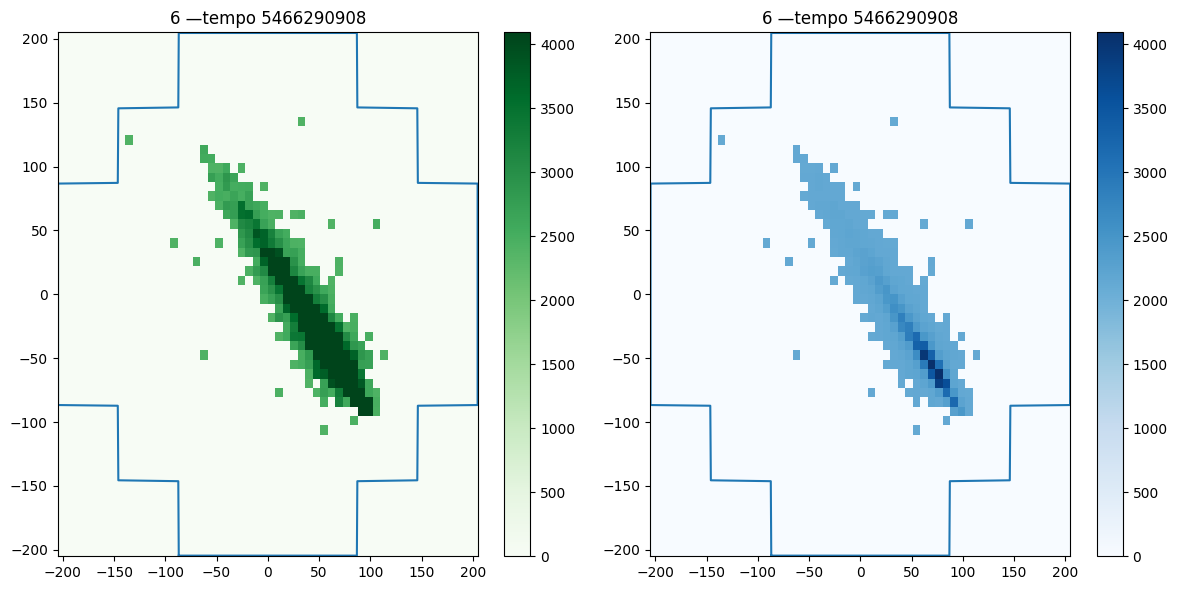

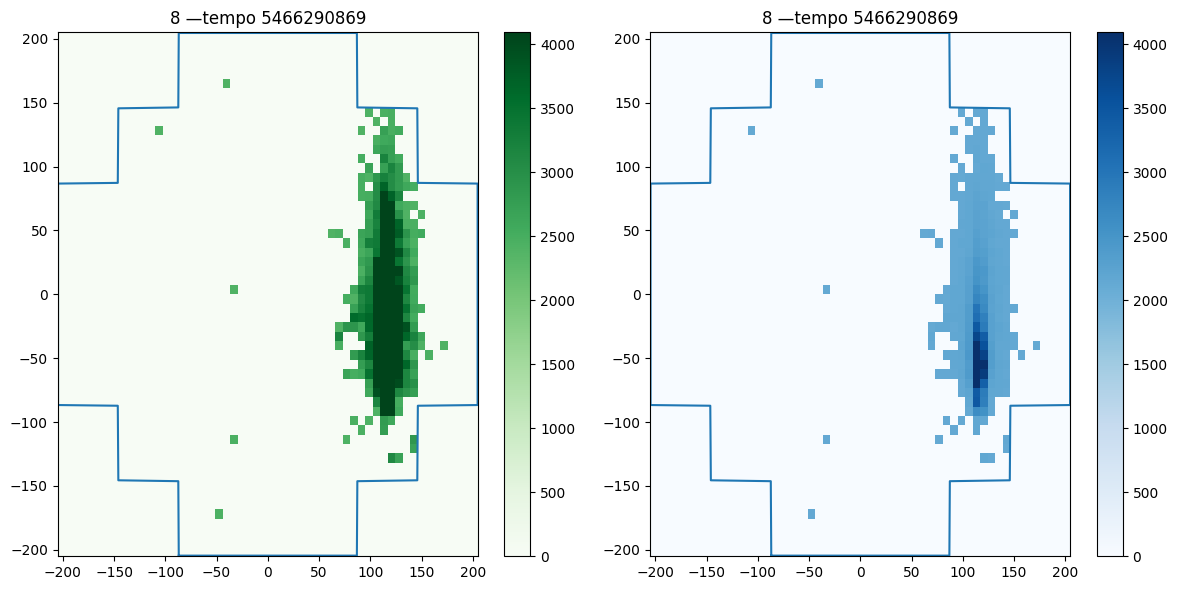

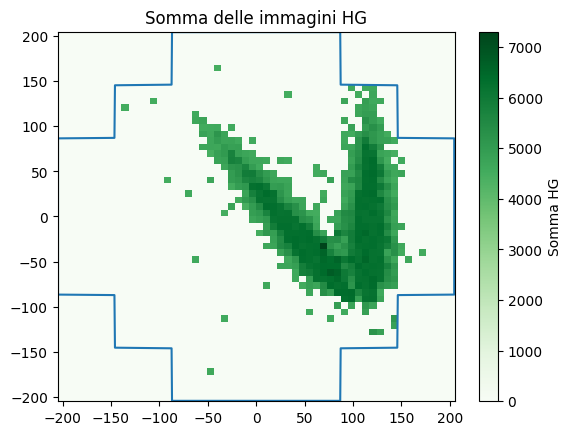

In [ ]:
weights = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)



for iev in top_indices[0:2]:
    hgev = np.array(df_all_sorted['HG'])[iev]
    weights += hgev  # somma elemento per elemento
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()
weights=np.array(weights)
plt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
plt.plot(xfp, yfp)
plt.colorbar(label='Somma HG')
plt.title('Somma delle immagini HG')
plt.show()


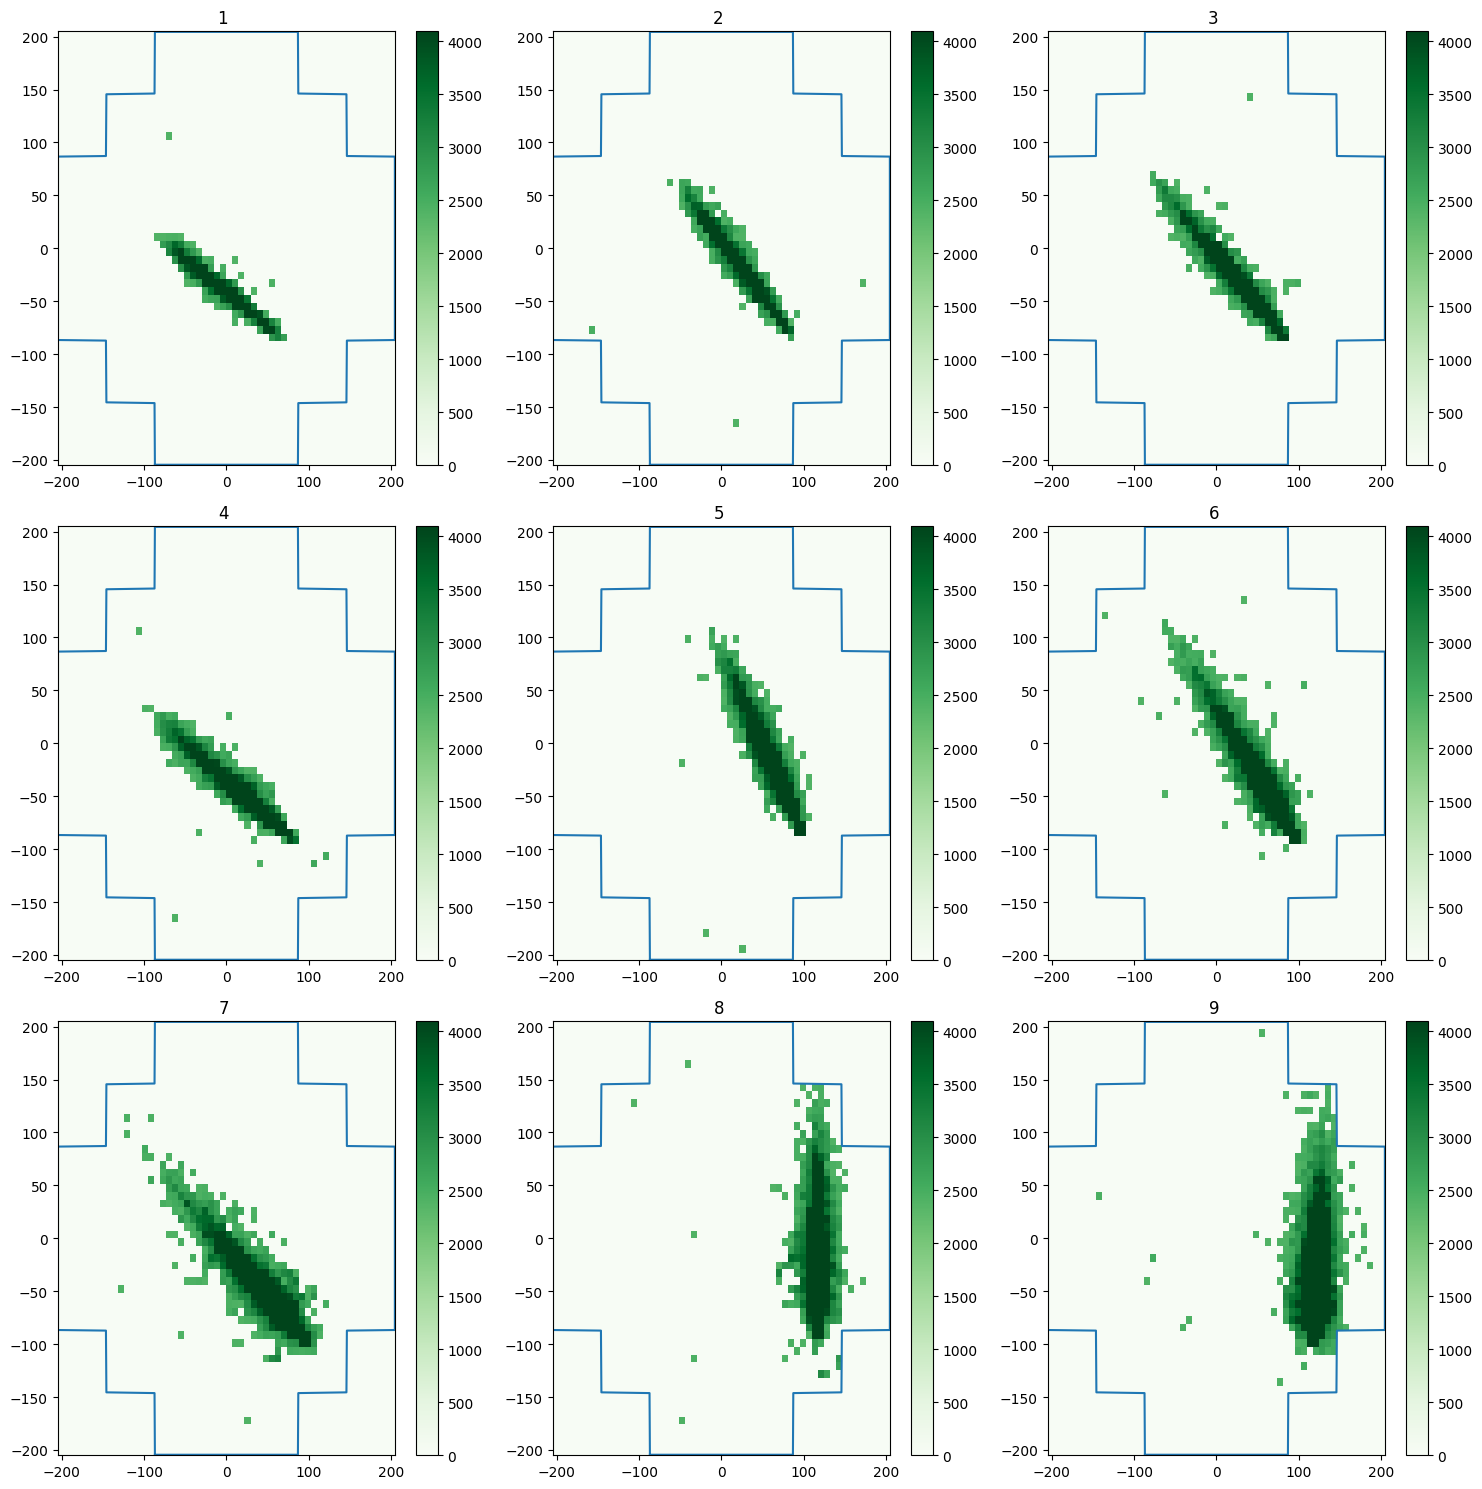

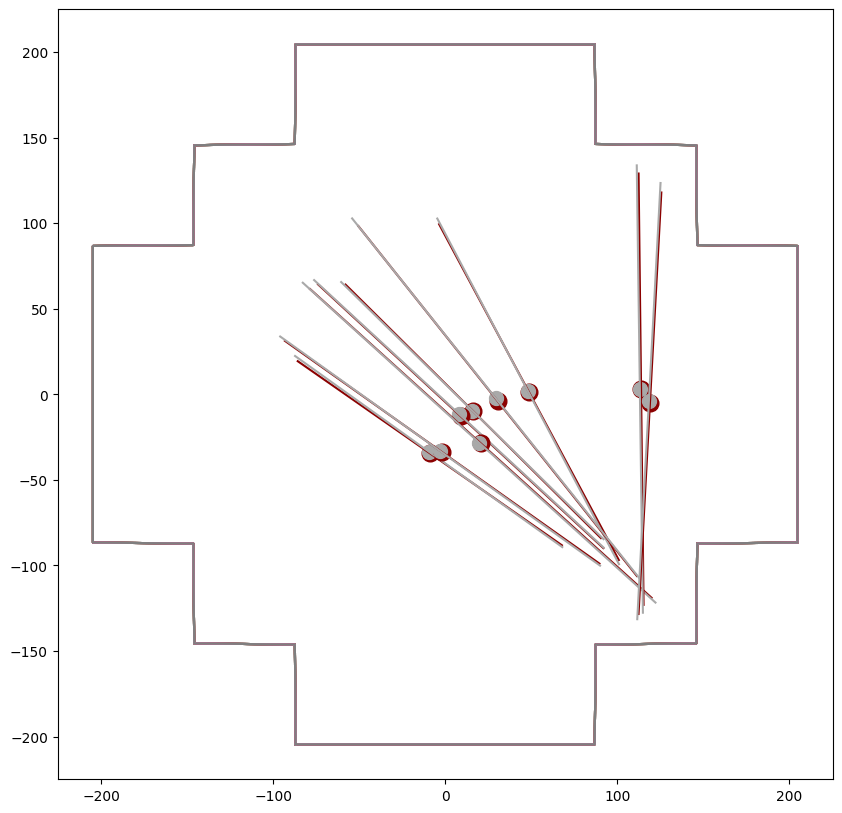

In [8]:
#stampo lo stesso evento, che già conosco
target=3109
target_mc =266033
df_target= df_all_sorted[
    (df_all_sorted['EVENT'] == target) &
    (df_all_sorted['MCRUN'] == target_mc)
]
df_target=df_target.sort_values(by='TEL_ID')
peso = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)


fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    peso += hgev  # somma elemento per elemento

    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
       
        # plot
    row = itel // 3  # calcola riga
    col = itel % 3   # calcola colonna
    ax = axes[row, col]
    hl = ax.hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    '''
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    '''
    fig.colorbar(hl[3], ax=ax)
    ax.plot(xfp, yfp)
    ax.set_title(f"{df_target['TEL_ID'].iloc[itel]} ")

plt.show()
#studio di uno stesso evento
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)
#raccolgo le rette
rette=[]

for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    ax.plot(xfp, yfp)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    #raccolgo le rette
    rette.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel,
        #"tipo": "HG"-----------> per il momento solo hg
    })
    ax.plot(xfp, yfp)
            #centroidi
    ax.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
    ax.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette
    ax.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
    ax.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
plt.show()

In [11]:

#intersezione tra rette
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  # parallele → nessuna intersezione

    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
N = len(rette)
inters=[]
for i in range(N):
    p1=rette[i]["p0"]
    d1 = rette[i]["d"]
    for j in range(i+1, N):
        p2=rette[j]["p0"]
        d2 = rette[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters.append(P)
inters = np.array(inters)
valid_points = []
eps=8.#da definire
for i, p in enumerate(inters):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters - p)**2, axis=1))
    
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    
    # se abbastanza intersezioni vicine → salva
    if n >= 3:
        valid_points.append(p)

valid_points = np.array(valid_points)
print(valid_points)


[[ 158.19291355 -151.56375296]
 [ 158.52861173 -151.79898748]
 [ 113.20926783 -120.04226493]
 [ 115.23633142 -121.46269362]
 [ 112.80011737 -119.75556004]
 [ 157.07070204 -150.44396679]
 [ 144.94959248 -138.34905364]
 [ 106.35463148  -99.83750489]
 [ 115.08769062 -108.55168996]
 [ 113.48820637 -106.95566254]
 [ 141.1335426  -135.63153995]
 [ 102.29488577  -99.53384229]
 [ 116.75128177 -112.97000756]
 [ 115.12111431 -111.45488585]
 [ 113.33555291 -109.79533681]
 [ 109.52740448 -113.12394291]
 [ 126.36664151 -125.11562504]
 [ 128.04158356 -126.30839717]
 [ 115.18672781 -117.15410213]
 [ 113.02280449 -115.61311304]
 [ 105.77129831 -106.06611661]
 [ 115.26443733 -123.90398467]
 [ 112.82365612 -119.31768998]
 [ 125.43599712 -123.94008391]
 [ 115.11475873 -110.9028376 ]
 [ 113.39293447 -108.72791961]
 [ 115.15729311 -114.59739216]
 [ 113.17430011 -112.79497695]]


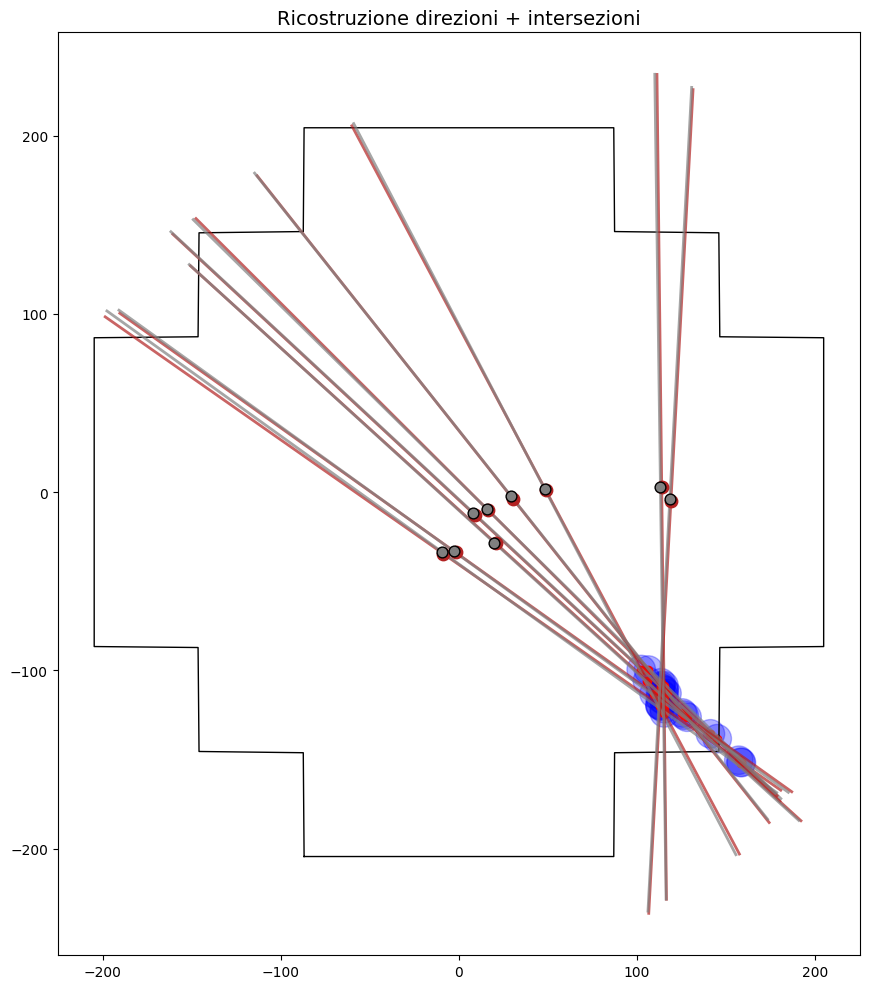

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())

    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
            #centroidi
    ax.scatter(meanx_hg, meany_hg, s=80, color='firebrick', zorder=5)
    ax.scatter(meanx_lg, meany_lg, s=60, color='grey', edgecolor='black', zorder=5)
            #le rette
    #HG
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax.plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.7)

    # LG
    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.7)
for x, y in valid_points:
    cerchio = plt.Circle((x, y), eps, color='blue', alpha=0.3, fill=True)
    ax.add_patch(cerchio)
ax.scatter(valid_points[:,0], valid_points[:,1], marker="o",c="red")

ax.set_aspect('equal', 'box')
ax.grid(False)
ax.set_title("Ricostruzione direzioni + intersezioni", fontsize=14)
plt.tight_layout()
plt.show()

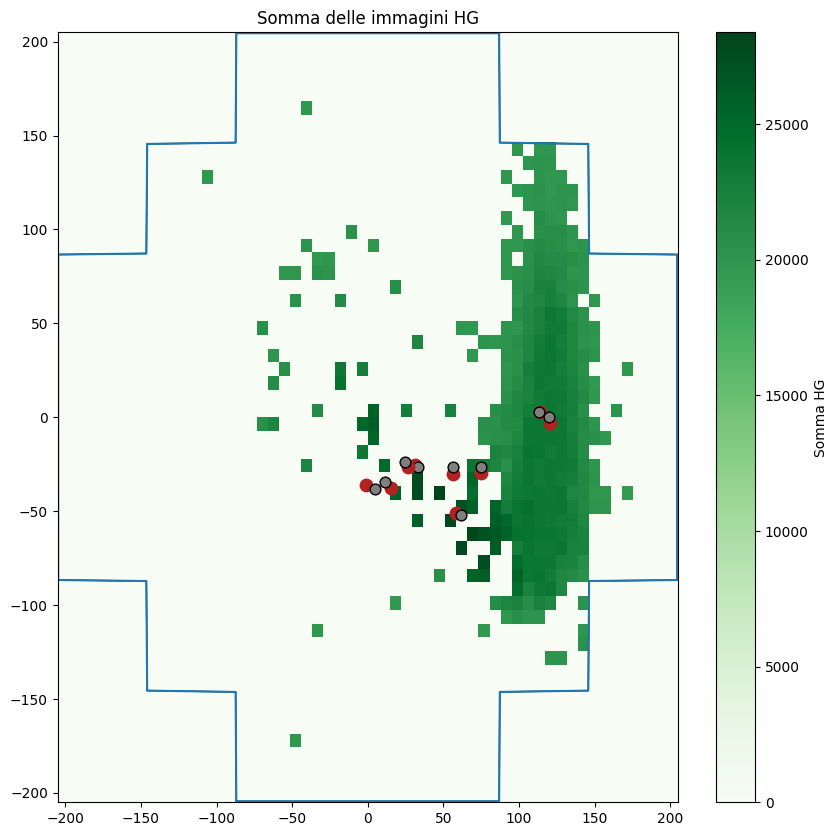

In [44]:
#somma di immagini
weights_hg = np.zeros_like(np.array(df_all_sorted['HG'])[0])
weights_lg = np.zeros_like(np.array(df_all_sorted['LG'])[0])

mask_tot = np.zeros((37, 64), dtype=bool)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
for itel in range(9):
    hgev = np.array(df_target['HG'])[itel]
    weights_hg += hgev  # somma elemento per elemento
    lgev = np.array(df_all_sorted['LG'])[iev]
    weights_lg += lgev  
    ttpev = np.array(df_all_sorted['TTP'])[iev]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask

    ttpev = np.array(df_target['TTP'])[itel]
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())

    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
            #centroidi
    ax.scatter(meanx_hg, meany_hg, s=80, color='firebrick', zorder=5)
    ax.scatter(meanx_lg, meany_lg, s=60, color='grey', edgecolor='black', zorder=5)
    """
            #le rette
    #HG
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax.plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.7)

    # LG
    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.7)
    """
weights_hg=np.array(weights_hg)
plt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights_hg[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
plt.plot(xfp, yfp)
plt.colorbar(label='Somma HG')
plt.title('Somma delle immagini HG')
plt.show()


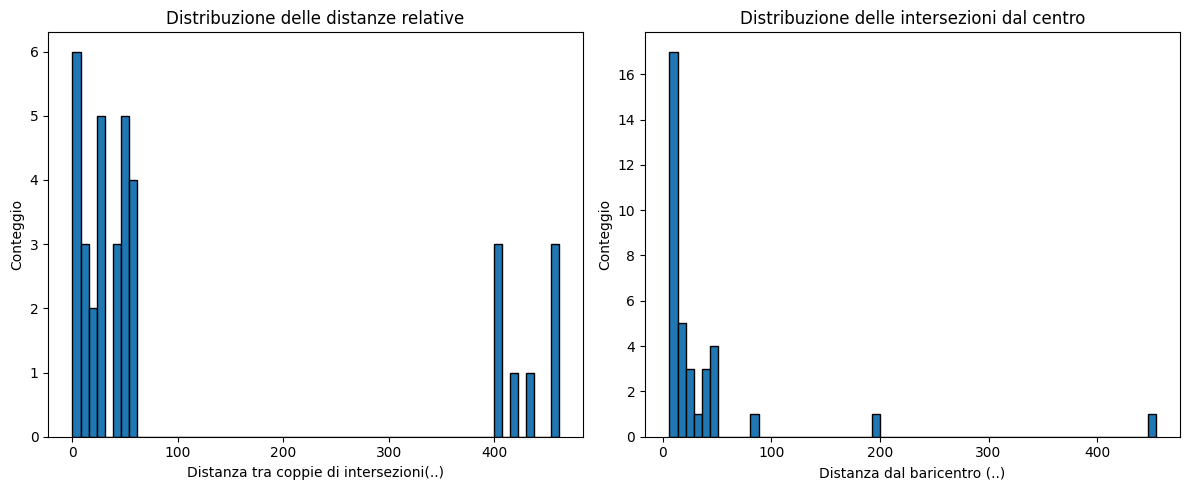

In [38]:
dists = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(inters[i] - inters[j])
        dists.append(dij)

dists = np.array(dists)
centro = np.mean(valid_points, axis=0)
dists_center = np.linalg.norm(inters - centro, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Istogramma 1: Distanze tra coppie
axes[0].hist(dists, bins=60, edgecolor='black')
axes[0].set_xlabel("Distanza tra coppie di intersezioni(..)")
axes[0].set_ylabel("Conteggio")
axes[0].set_title("Distribuzione delle distanze relative")

# Istogramma 2: Distanze dal baricentro
axes[1].hist(dists_center, bins=60, edgecolor='black')
axes[1].set_xlabel("Distanza dal baricentro (..)")
axes[1].set_ylabel("Conteggio")
axes[1].set_title("Distribuzione delle intersezioni dal centro")

plt.tight_layout()
plt.show()

In [39]:

print(cov_hg)


[[ 971.25234186  152.12897595]
 [ 152.12897595 3792.99210402]]


In [ ]:
#seconda prova
